In [1]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-mypmacah
  Running command git clone -q https://github.com/openai/glide-text2im /tmp/pip-req-build-mypmacah
     |████████████████████████████████| 64 kB 961 kB/s 
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953654 sha256=876c2aafdc34ff0f7890823e189299ef9f9a6c0fdc273ee006f6fbc5169235b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2rqfbi2/wheels/b4/36/07/46711fd6462da277046c6720504e61546b6e32adc0293abc96
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=c48840020c2b10da6cfded1a2d78311894602ade263b820c35d525a6f64f8e31
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built glide-text2im ftfy


In [2]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [3]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [4]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [6]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [15]:
# Sampling parameters
prompt = "a pixel art cat tree"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

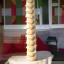

In [16]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

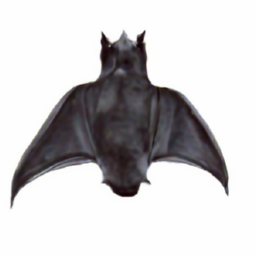

In [14]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)